# Dataset

In [96]:
import pandas as pd
import numpy as np
df = pd.read_csv('AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [97]:
df_bool = df.copy()
df_bool['card'] = df_bool['card'].replace(" ","").replace("yes",1).replace("no",0)
df_bool.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [121]:
from sklearn.model_selection import train_test_split

def get_split_data(data, seed, y_var_name):
    df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=seed)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train[y_var_name].values
    y_val = df_val[y_var_name].values
    y_test = df_test[y_var_name].values

    del df_train[y_var_name]
    del df_val[y_var_name]
    del df_test[y_var_name]
    
    return df_full_train, df_train, df_val, df_test, y_train, y_val, y_test

df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = get_split_data(df_bool, 1, "card")
print(len(df_full_train), len(df_train), len(y_train))

791 791


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`  <-

In [103]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

numeric = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']
no_numeric = ['owner', 'selfemp']

for f in numeric:
    auc = roc_auc_score(y_train, df_train[f])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[f])
    print('%9s, %.3f' % (f, auc))

791 791
  reports, 0.733
      age, 0.503
   income, 0.575
    share, 0.989
expenditure, 0.989
dependents, 0.527
   months, 0.518
majorcards, 0.560
   active, 0.591


## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [107]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

df_train, df_val, df_test, y_train, y_val, y_test = get_split_data(df_bool, 0, "card")

columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

# DataTrain one-hot encoding
train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

# Model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# DataVal one-hot encoding
val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Prediction
y_pred = model.predict_proba(X_val)[:, 1]

y_pred_bin = model.predict(X_val)

print(y_pred, y_pred_bin)

[1.00000000e+00 3.30301821e-02 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.74566414e-01 1.00000000e+00 1.00000000e+00
 2.31912602e-02 2.25029612e-01 1.00000000e+00 9.99983555e-01
 5.28765930e-01 1.82592120e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.97008289e-01 1.00000000e+00 3.47673205e-01 4.71646574e-08
 3.26716038e-02 1.00000000e+00 1.00000000e+00 4.95239866e-01
 9.99999024e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.99996855e-01 1.00000000e+00
 1.00000000e+00 2.68837228e-01 1.00000000e+00 1.64681287e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 4.60650365e-04
 3.50280112e-02 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.19993714e-02 2.53888606e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.000000

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995  <-

0.992964824120603 0.9566679551604175


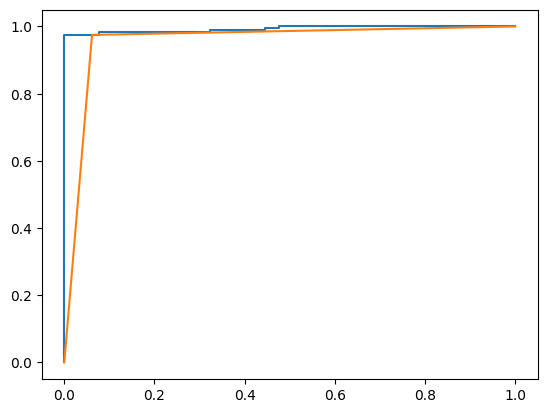

In [108]:
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')
fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

auc = roc_auc_score(y_val, y_pred)
auc_bin = roc_auc_score(y_val, y_pred_bin)
print(auc, auc_bin)

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3  <-
* 0.6
* 0.8

In [88]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 1001)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [112]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores[400:600:10]

,threshold,tp,fp,fn,tn,p,r
400,0.40,195,5,4,60,0.975000,0.979899
410,0.41,194,5,5,60,0.974874,0.974874
420,0.42,194,5,5,60,0.974874,0.974874
430,0.43,194,5,5,60,0.974874,0.974874
440,0.44,194,5,5,60,0.974874,0.974874
450,0.45,194,5,5,60,0.974874,0.974874
460,0.46,194,5,5,60,0.974874,0.974874
470,0.47,194,5,5,60,0.974874,0.974874
480,0.48,194,5,5,60,0.974874,0.974874
490,0.49,194,5,5,60,0.974874,0.974874


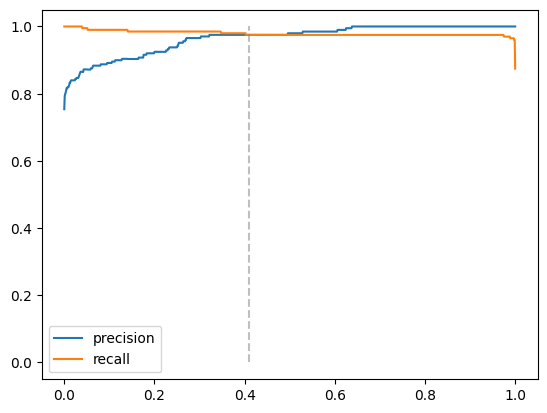

In [114]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.41, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7  <-


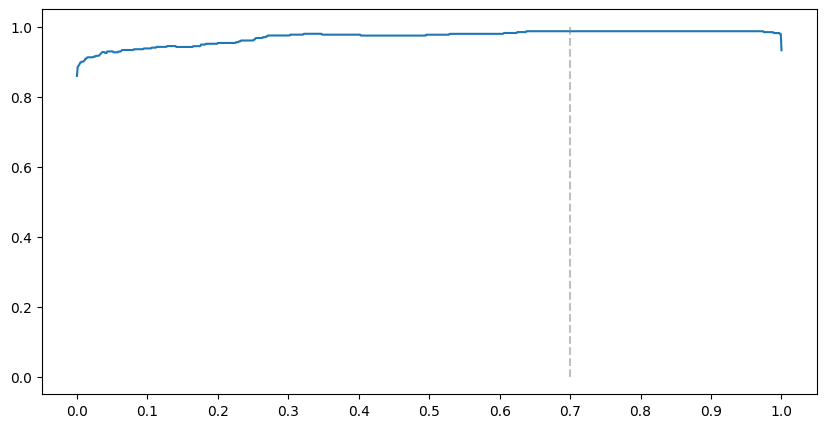

0       0.859611
100     0.938095
200     0.953771
300     0.975124
400     0.977444
500     0.977330
600     0.979798
700     0.987277
800     0.987277
900     0.987277
1000    0.932976
Name: f1, dtype: float64

In [118]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.7, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

df_scores['f1'][::100]

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [119]:
from sklearn.model_selection import KFold

def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [120]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

NameError: name 'df_full_train' is not defined

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C